In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import struct
import time
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm
import torchvision.transforms as transforms
from skimage.util import random_noise


# Loading dataset

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

t = transforms.Compose([
                       transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])]
                       )

train_dataset = torchvision.datasets.ImageFolder(
        root='data/mnist_png/training/',
        transform=t
    )
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=True
    )

test_dataset = torchvision.datasets.ImageFolder(
        root='data/mnist_png/testing/',
        transform=t
    )
test_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=True
    )

# Defining and Training Autoencoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.drop = nn.Dropout(0)
        self.fc1 = nn.Linear(32*7*7, 512)
        self.fc2 = nn.Linear(512, 256)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x, indices1 = self.pool2(x)
        x = F.leaky_relu(self.conv2(x))
        x, indices2 = self.pool2(x)
        x = F.leaky_relu(self.conv3(x))
        #x = F.leaky_relu(self.conv4(x))
        
        batch, _, _, _ = x.shape
        #x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = x.reshape(batch, -1)
        x = self.drop(F.leaky_relu(self.fc1(x)))
        x = self.drop(F.leaky_relu(self.fc2(x)))
        return x, indices1, indices2

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 32)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=7)
        self.drop = nn.Dropout(0)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3), padding=1)
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=(3,3), padding=1)
        self.conv3= nn.ConvTranspose2d(8, 1, kernel_size=(3,3), padding=1)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x, indices1, indices2):
        
        x = self.drop(F.leaky_relu(self.fc1(x)))
        x = self.drop(F.leaky_relu(self.fc2(x)))
        x = x.view(-1, x.shape[1], 1, 1)
        x = self.upsample(x)
        x = F.leaky_relu(self.conv1(x))
        x = self.unpool2(x, indices2)
        x = F.leaky_relu(self.conv2(x))
        x = self.unpool2(x, indices1)
        x = F.leaky_relu(self.conv3(x))
        x = self.sigmoid_activation(x)
        return x

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x, indices1, indices2 = self.encoder(x)
        x = self.decoder(x, indices1, indices2)
        return x

In [4]:
#noise adding funtion
def add_noise(inputs):
    n = np.random.choice([1,4])
    if n==1:
        noisy = transforms.RandomErasing(p=1, scale=(0.2,0.2), value=-1)(inputs)
    elif n==2:
        noisy = torch.zeros_like(inputs)
        for i in range(inputs.shape[0]):
            noisy[i] = torch.tensor(random_noise(inputs[i], mode='s&p', amount=0.2, clip=True))
    elif n==3:
        noisy = torch.zeros_like(inputs)
        for i in range(inputs.shape[0]):
            noisy[i] = torch.tensor(random_noise(inputs[i], mode='gaussian', mean=0, clip=True))
    elif n==4:
        noisy=inputs
    return noisy

In [5]:
model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,
                             weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

num_epochs=20
num_batches = len(train_loader) 
for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        img, labels = data
        n_img = add_noise(img)
        #labels=to_categorical(labels,classes) 
        n_img=n_img.cuda()
        img=img.cuda()
        labels=labels.cuda()
        # ===================forward=====================
        output = model(n_img.float())
        loss = criterion(img.float(), output)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if i%50==0:
        #    print('epoch [{}/{}], batch[{}/{}], loss:{:.4f}'.format(epoch+1,num_epochs, i,num_batches,  loss))
    # ===================log========================
    
    model.eval()
    loss_ts = []
    for i, data in enumerate(test_loader):
        img, labels = data
        img=img.cuda()
        labels=labels.cuda()
        # ===================forward=====================
        output = model(img.float())
        v_loss = criterion(img.float(), output)
        loss_ts.append(v_loss.detach().cpu().numpy())
    print('DONE with epoch [{}/{}], val loss:{:.4f}'.format(epoch+1, num_epochs, np.mean(loss_ts)))

DONE with epoch [1/20], val loss:0.9253
DONE with epoch [2/20], val loss:0.9020
DONE with epoch [3/20], val loss:0.8816
DONE with epoch [4/20], val loss:0.8660
DONE with epoch [5/20], val loss:0.8578
DONE with epoch [6/20], val loss:0.8548
DONE with epoch [7/20], val loss:0.8525
DONE with epoch [8/20], val loss:0.8514
DONE with epoch [9/20], val loss:0.8504
DONE with epoch [10/20], val loss:0.8498
DONE with epoch [11/20], val loss:0.8494
DONE with epoch [12/20], val loss:0.8485
DONE with epoch [13/20], val loss:0.8484
DONE with epoch [14/20], val loss:0.8484
DONE with epoch [15/20], val loss:0.8481
DONE with epoch [16/20], val loss:0.8479
DONE with epoch [17/20], val loss:0.8478
DONE with epoch [18/20], val loss:0.8487
DONE with epoch [19/20], val loss:0.8473
DONE with epoch [20/20], val loss:0.8472


# Getting embeddings from latent space and applying PCA

In [6]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        x, i1, i2 = output
        activation[name] = x.detach()
    return hook


#model = Autoencoder()
model.encoder.register_forward_hook(get_activation('encoder'))

In [7]:
test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)

test_targets = []
test_embeddings = torch.zeros((0, 256), dtype=torch.float32)
for x,y in test_loader:
    x = x.cuda()
    recons = model(x.float())
    #preds = torch.argmax(logits, dim=1)
    #test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    feat_maps = activation['encoder'].detach().cpu()
    embeddings = feat_maps.reshape(feat_maps.shape[0], 256)
    test_embeddings = torch.cat((test_embeddings, embeddings), 0)
#    test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
#test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
#test_predictions = np.array(test_predictions)

In [8]:
pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_

array([0.90103674, 0.07450159], dtype=float32)

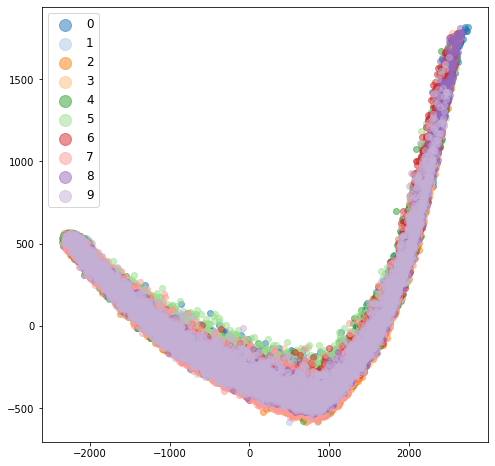

In [9]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

Also found this alternative to PCA for projection/visualization (TSNE), looks a bit better but runtime is significantly longer

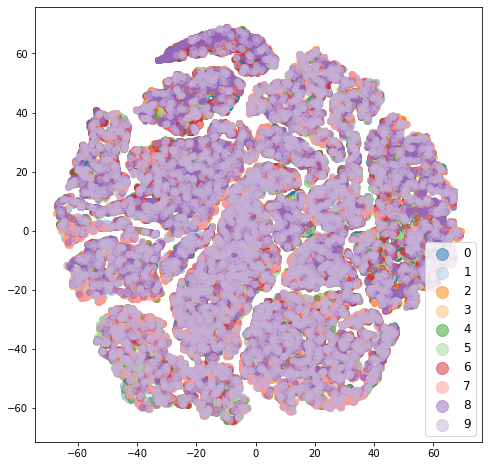

In [10]:
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [11]:
def fisher_score(X, Y, numclasses):
    mu = np.mean(X, axis = 0)
    num = np.zeros(mu.shape) - mu**2
    den = np.zeros(mu.shape)
    for c in range(numclasses):
        group = X[Y == c]
        n = group.shape[0]
        mu_c = np.mean(group, axis=0)
        sigma_c = np.std(group, axis =0)
        num = num + n*mu_c
        den = den + n*(sigma_c**2)
    return num/den
        
    

In [12]:
fisher_score(pca_proj, test_targets, 10)

array([ 7.01300998e-09, -1.37308430e-08])

In [13]:
fisher_score(tsne_proj, test_targets, 10)

array([-0.00011598, -0.00018593])

In [14]:
def construct_dist_matrix(X, Y, numclasses):
    dmat = np.zeros((numclasses, numclasses))
    for i in range(numclasses):
        g_i = X[Y == i]
        for j in range(i, numclasses):
            g_j = X[Y == j]
            d = CSM_fast(g_i, g_j)
            dmat[i,j] = d
            dmat[j,i] = d
    return dmat


def CSM(g1,g2):
    m1 = np.mean(g1, axis=0)
    m2 = np.mean(g2, axis=0)
    m = np.mean(np.concatenate((g1,g2), axis=0), axis=0)
    S_b = np.outer(m1-m,m1-m) + np.outer(m2-m,m2-m)
    S_w = np.zeros(S_b.shape)
    for i in range(g1.shape[0]):
        S_w = S_w + np.outer(g1[i] - m1, g1[i] - m1)
    for i in range(g2.shape[0]):
        S_w = S_w + np.outer(g2[i] - m2, g2[i] - m2)
        
    return np.matrix.trace(S_b)/np.matrix.trace(S_w)

def CSM_fast(g1,g2):
    m1 = np.mean(g1, axis=0)
    m2 = np.mean(g2, axis=0)
    m = np.mean(np.concatenate((g1,g2), axis=0), axis=0)
    S_b = np.sum((m1-m)**2 + (m2-m)**2)
    S_w = 0 
    for i in range(g1.shape[0]):
        S_w = S_w + np.sum((g1[i] - m1)**2)
    for i in range(g2.shape[0]):
        S_w = S_w + np.sum((g2[i] - m2)**2)
    
    return S_b/S_w
            

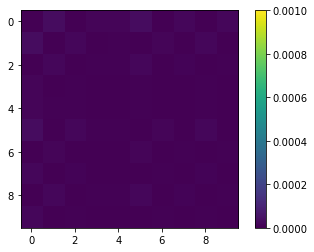

Frob norm for DM is 0.00010189501638992541


In [15]:
DM = construct_dist_matrix(test_embeddings, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM, vmin=0, vmax=1e-03)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))

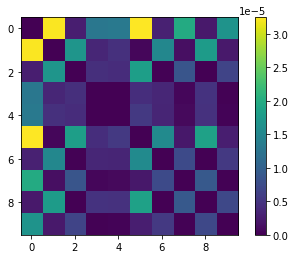

Frob norm for DM is 0.00010401592861660448


In [16]:
DM = construct_dist_matrix(pca_proj, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))

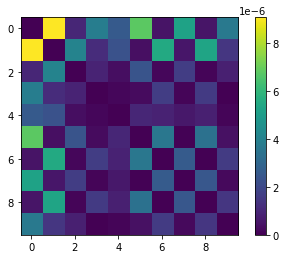

Frob norm for DM is 2.5934042995882973e-05


In [17]:
DM = construct_dist_matrix(tsne_proj, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))

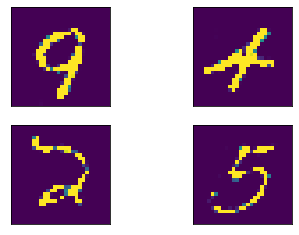

In [18]:
def show_images(feats):
    for digit_num in range(4): 
        plt.subplot(2,2,digit_num+1) #create subplots
        plt.imshow(feats[digit_num][0]) #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis
show_images(output.detach().cpu())

In [19]:
n = add_noise(img.detach().cpu())

In [20]:
img[0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1